# Importing libraries & dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [4]:
train_df= pd.read_csv('data/train.csv').drop(columns= 'id')
test_df= pd.read_csv('data/test.csv')

In [5]:
train_df.head(10)

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4  female   38   166.0    61.0      25.0       102.0       40.6     146.0
5  female   26   156.0    56.0      19.0       100.0       40.5     103.0
6  female   21   172.0    73.0       3.0        81.0       38.3       9.0
7    male   46   188.0    94.0      23.0       100.0       40.8     145.0
8  female   33   166.0    63.0      25.0       107.0       40.5     161.0
9    male   65   185.0    88.0      23.0       104.0       41.0     185.0

In [6]:
train_df.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [7]:
print(f'Dataset shape: {train_df.shape}')
train_df.info()

Dataset shape: (750000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ MB


# Exploratory Data Analysis

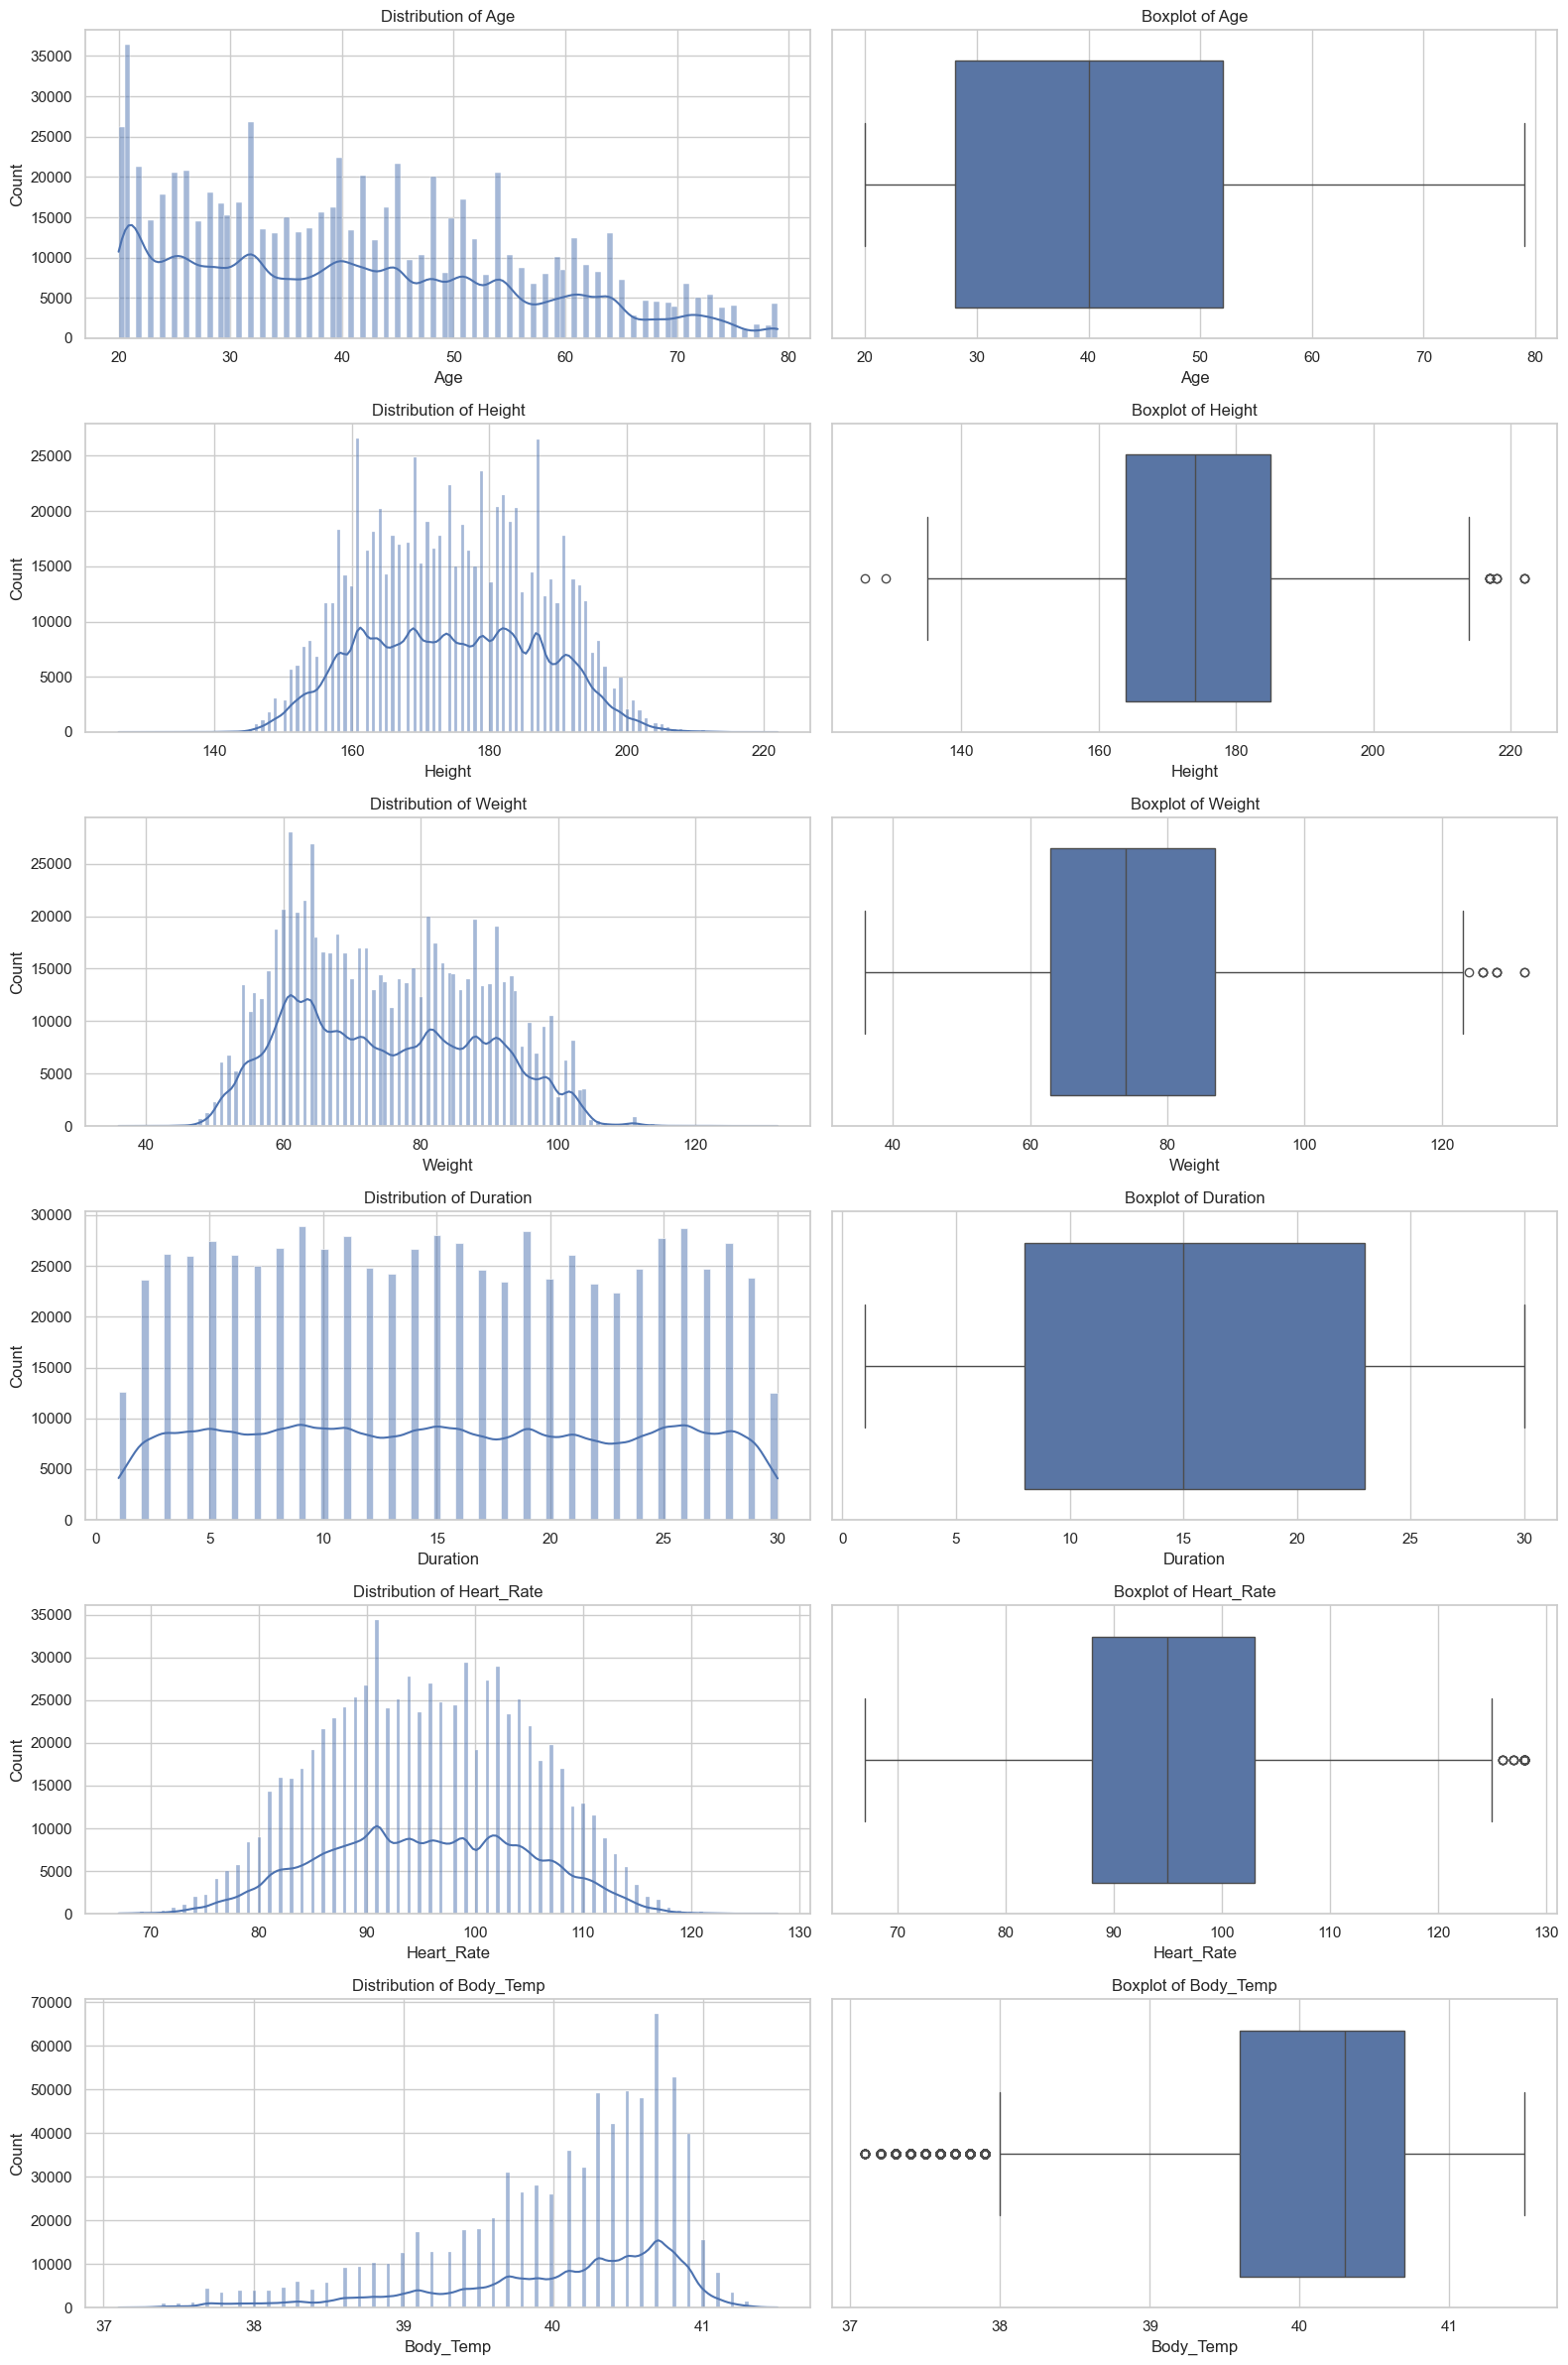

In [8]:
def plot_distributions(df, columns):
    n = len(columns)
    fig, axes = plt.subplots(n, 2, figsize=(16, 4*n))
    
    for i, col in enumerate(columns):
        # Histogram plot
        sns.histplot(df[col], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {col}')
        
        # Box plot
        sns.boxplot(x=df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
plot_distributions(train_df, numerical_cols)

Visualization Analysis

| Feature    | Shape of Distribution | Skew | Outliers | Notes                                     |
| ---------- | --------------------- | ---- | -------- | ----------------------------------------- |
| Age        | Right-skewed          | Yes  | Few      | Younger population is dominant            |
| Height     | Normal                | No   | Some     | Standard human height distribution        |
| Weight     | Slightly right-skewed | Yes  | Yes      | Overweight individuals exist              |
| Duration   | Uniform               | No   | None     | Even spread, likely time-limited activity |
| Heart Rate | Normal                | No   | Yes      | Outliers with high bpm                    |
| Body Temp  | Right-skewed          | Yes  | Yes      | Unusual number of low outliers            |


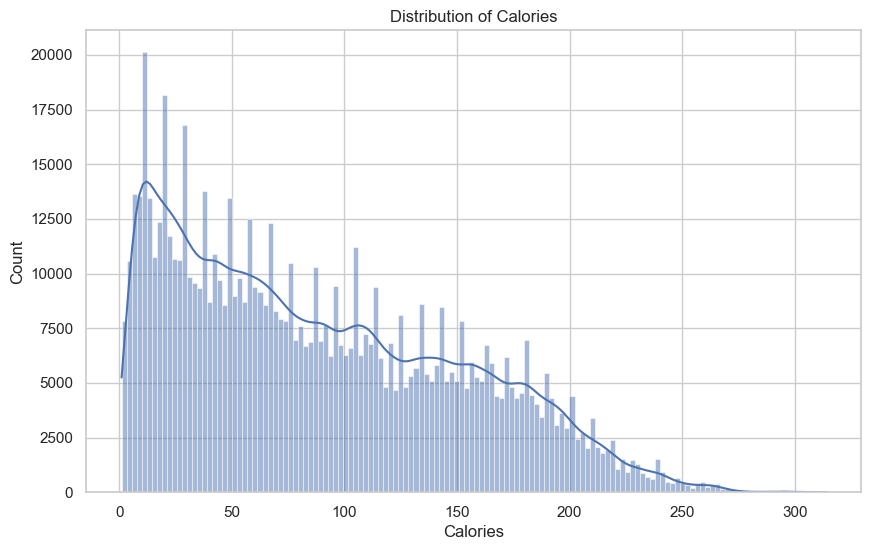

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Calories'], kde= True)
plt.title('Distribution of Calories')
plt.show()

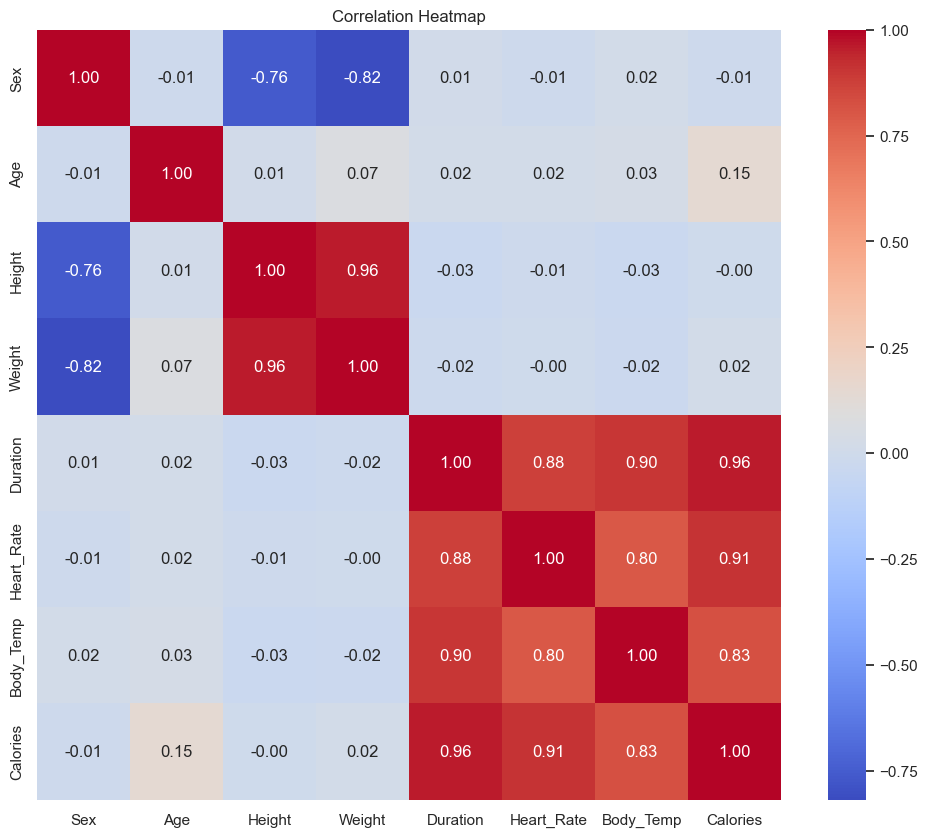

In [10]:
plt.figure(figsize=(12, 10))
train_df_numeric = train_df.copy()
train_df_numeric['Sex'] = train_df_numeric['Sex'].map({'male': 0, 'female': 1})
correlation_matrix = train_df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

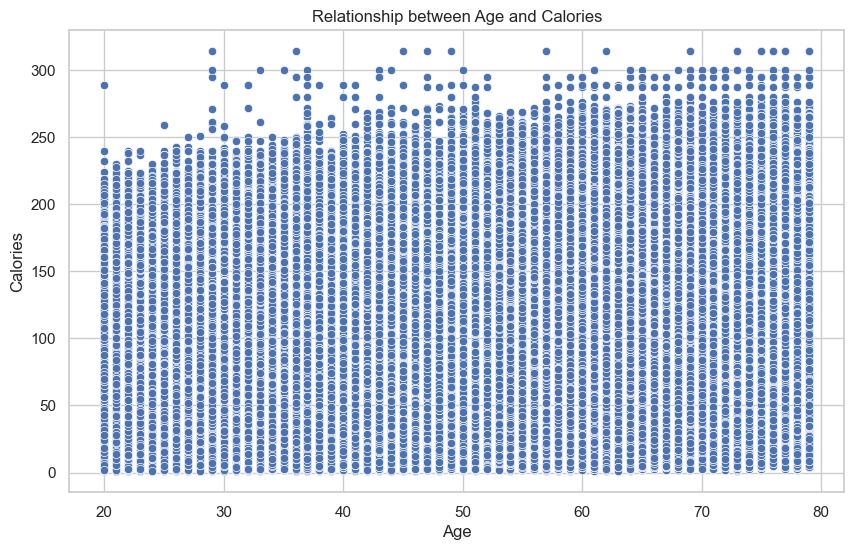

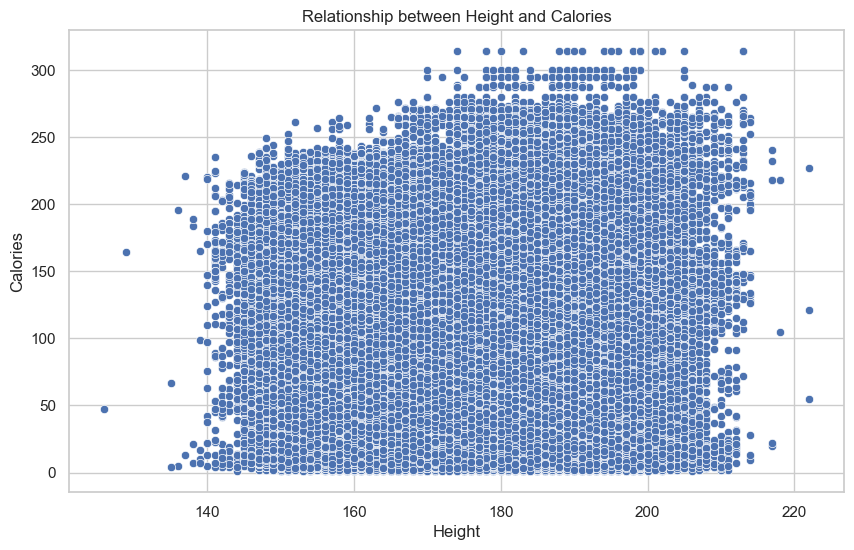

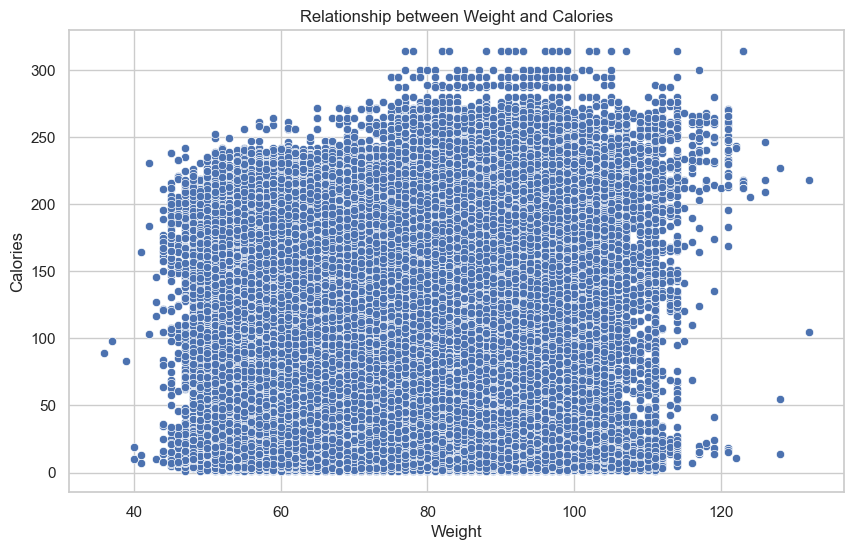

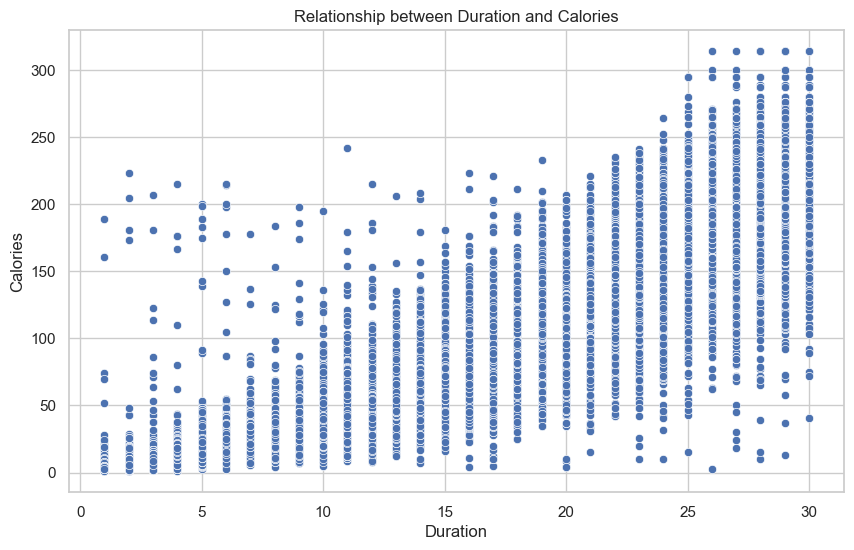

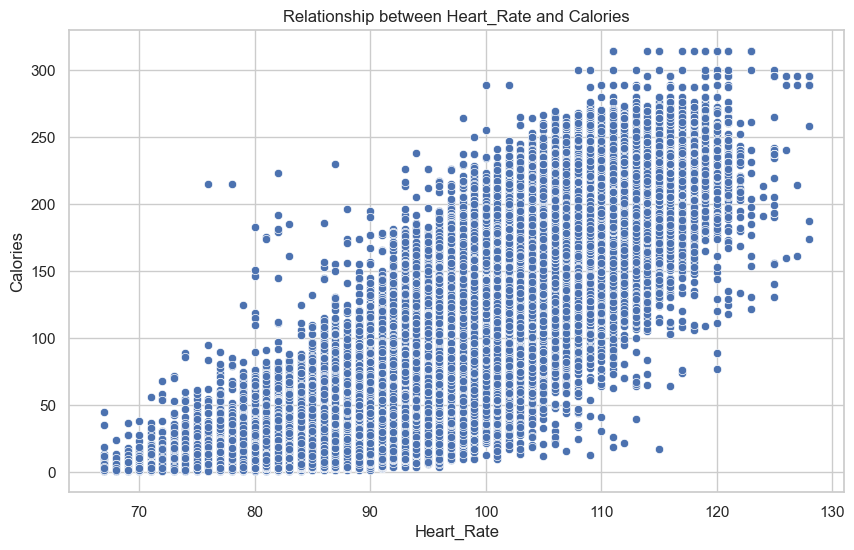

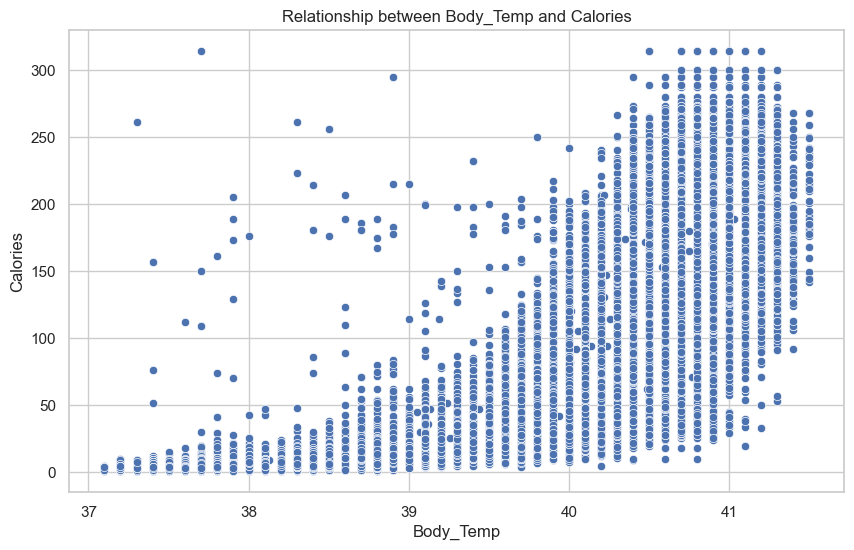

In [11]:
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=train_df[col], y=train_df['Calories'])
    plt.title(f'Relationship between {col} and Calories')
    plt.show()

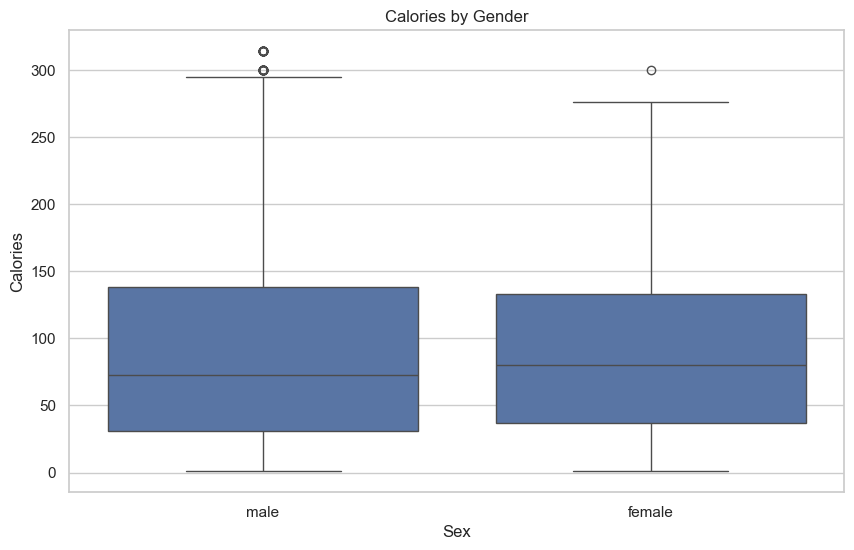

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Calories', data=train_df)
plt.title('Calories by Gender')
plt.show()

In [13]:
# outlier Detection
def detect_outliers(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_count[col] = len(outliers)
    
    return outliers_count

print("Outliers per column:")
print(detect_outliers(train_df, numerical_cols + ['Calories']))

Outliers per column:
{'Age': 0, 'Height': 14, 'Weight': 9, 'Duration': 0, 'Heart_Rate': 36, 'Body_Temp': 14919, 'Calories': 139}


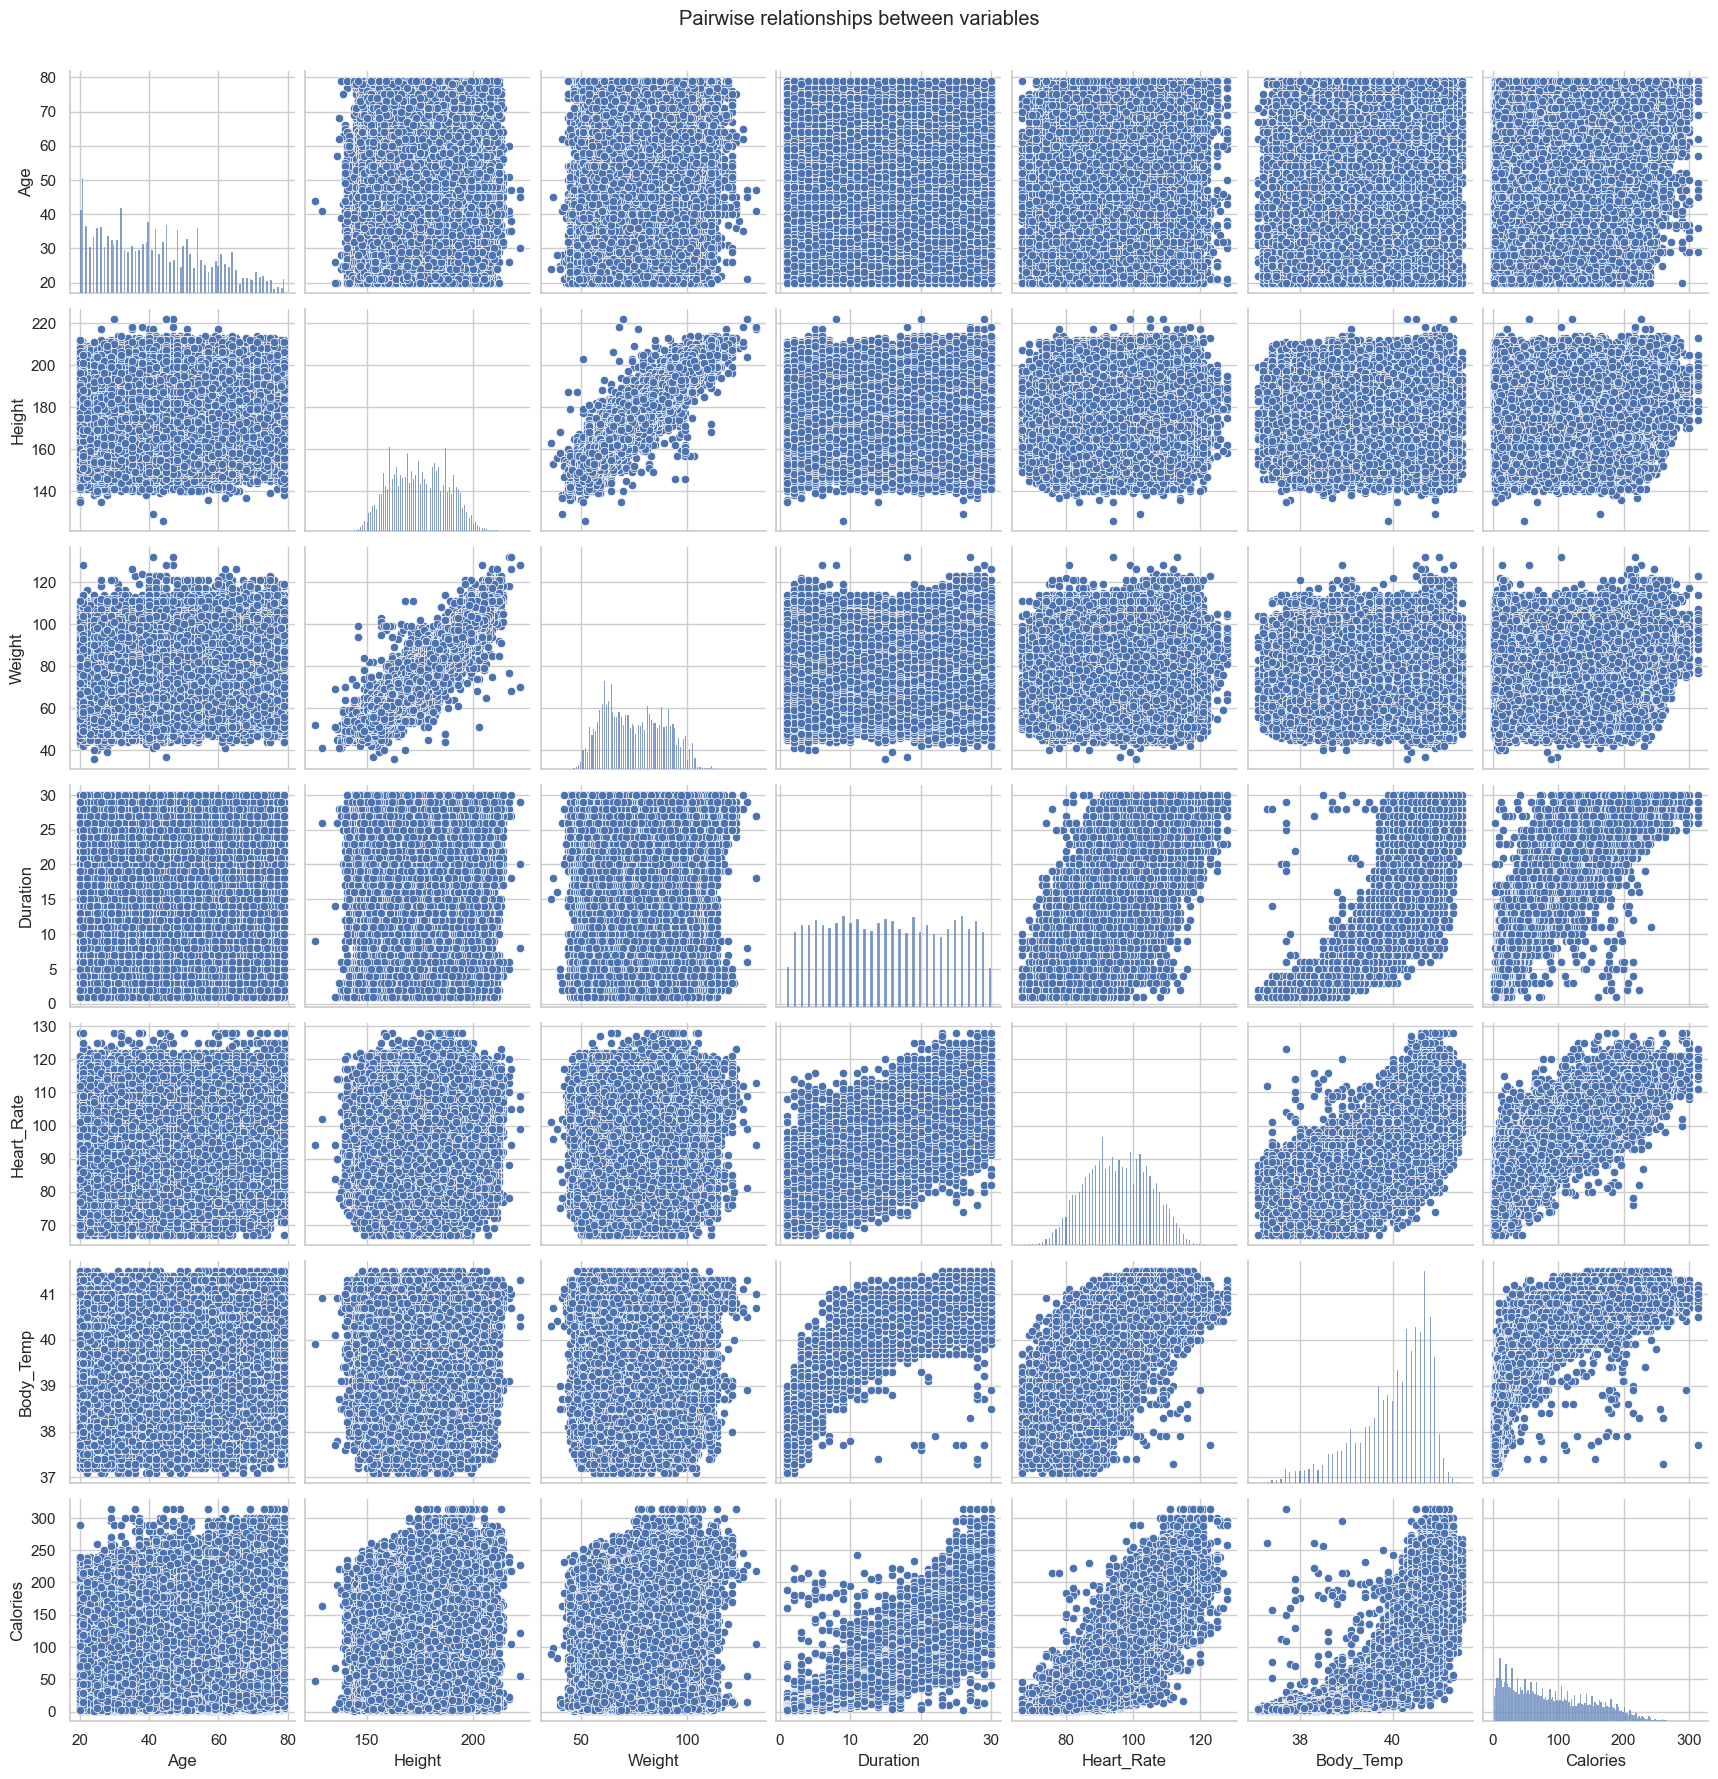

In [14]:
sns.pairplot(train_df[numerical_cols + ['Calories']])
plt.suptitle('Pairwise relationships between variables', y=1.02)
plt.show()

# Data Preprocessing

In [15]:
# Detect and handle outliers
def handle_outliers(df, columns, method='clip'):
    df_processed = df.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if method == 'clip':
            df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)
        elif method == 'remove':
            mask = (df_processed[col] >= lower_bound) & (df_processed[col] <= upper_bound)
            df_processed = df_processed[mask]
    
    return df_processed

In [16]:
# Function to detect and transform skewed features
def handle_skewness(df, columns, threshold=0.5):
    df_processed = df.copy()
    transformed_features = {}

    for col in columns:
        skewness = df[col].skew()
        transformed_features[col] = {'original_skewness': skewness, 
                                    'transformed_skewness': None}
        
        if abs(skewness) > threshold:
            # +ve skewness (Right skewed), log transformation
            if skewness > 0:
                min_val = df[col].min()
                shift = 0 if min_val > 0 else abs(min_val) + 1
                df_processed[col] = np.log1p(df[col] + shift)
                transformed_features[col]['transformation']= f'log1p(x+ {shift})'

            # -ve skewness (Left skewed), Square transformation
            elif skewness < 0:
                    df_processed[col] = np.square(df[col])
                    transformed_features[col]['transformation']= 'x^2'
        
        transformed_features[col]['new_skewness'] = df_processed[col].skew()
    return df_processed, transformed_features

In [17]:
def plot_skewness_comparison(df_original, df_transformed, columns, transformed_features):
	for col in columns:
		if col in transformed_features and 'transformation' in transformed_features[col]:
			fig, axes = plt.subplots(1, 2, figsize=(14, 5))
			
			# Original distribution
			sns.histplot(df_original[col], kde=True, ax=axes[0])
			axes[0].set_title(f'Original {col} (Skew: {transformed_features[col]["original_skewness"]:.2f})')
			
			# Transformed distribution
			sns.histplot(df_transformed[col], kde=True, ax=axes[1])
			axes[1].set_title(f'Transformed {col} (Skew: {transformed_features[col]["new_skewness"]:.2f})\n{transformed_features[col]["transformation"]}')
			
			plt.tight_layout()
			plt.show()

In [18]:
df_processed = handle_outliers(train_df, numerical_cols + ['Calories'], method='clip')

In [19]:
print("\nSkewness before transformation:")
print(df_processed[numerical_cols + ['Calories']].skew())


Skewness before transformation:
Age           0.436397
Height        0.051734
Weight        0.211052
Duration      0.026259
Heart_Rate   -0.005996
Body_Temp    -0.941104
Calories      0.538397
dtype: float64


In [20]:
df_transformed, transformed_features = handle_skewness(df_processed, numerical_cols + ['Calories'], threshold=0.5)

# Check skewness after transformation
print("\nSkewness after transformation:")
print(df_transformed[numerical_cols + ['Calories']].skew())


Skewness after transformation:
Age           0.436397
Height        0.051734
Weight        0.211052
Duration      0.026259
Heart_Rate   -0.005996
Body_Temp    -0.903499
Calories     -0.857076
dtype: float64


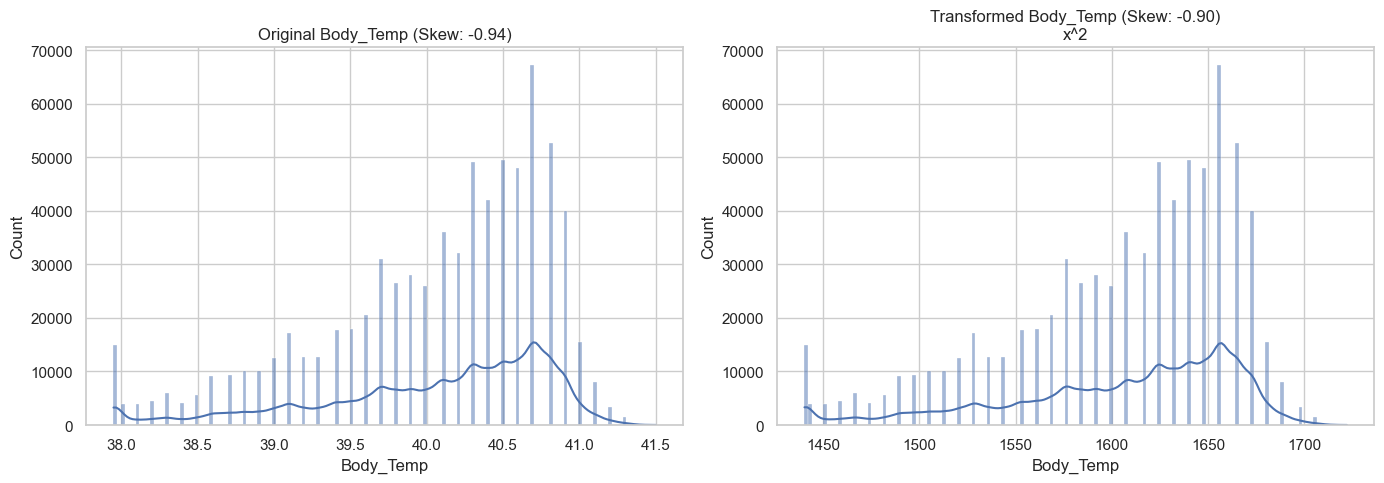

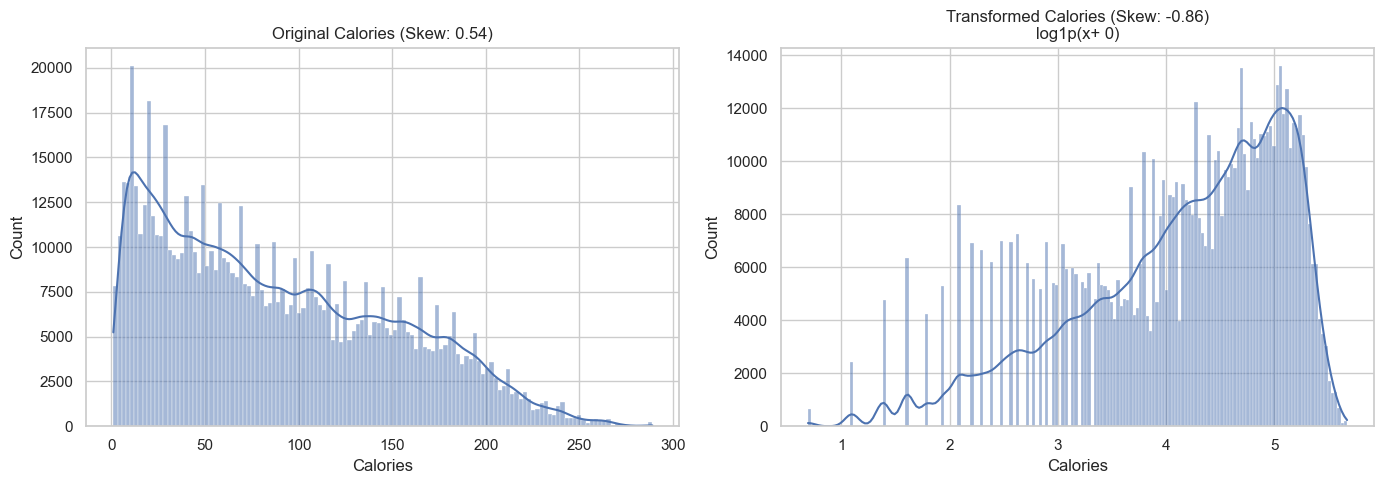

In [21]:
plot_skewness_comparison(df_processed, df_transformed, numerical_cols + ['Calories'], transformed_features)

In [22]:
df_transformed = pd.get_dummies(df_transformed, columns=['Sex'])

In [23]:
X = df_transformed.drop('Calories', axis=1)
y = df_transformed['Calories']

In [24]:
# Feature Scaling
scaler = StandardScaler()
for col in X.columns:
    X[col] = scaler.fit_transform(X[[col]])


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Feature Engineering & Selection

In [26]:
def plot_feature_importances_correlation(X, y):
    correlations = []
    for col in X.columns:
        correlation = np.corrcoef(X[col], y)[0, 1]
        correlations.append((col, abs(correlation)))
    
    # Sort by absolute correlation and create a DataFrame
    correlations.sort(key=lambda x: x[1], reverse=True)
    corr_df = pd.DataFrame(correlations, columns=['Feature', 'Absolute Correlation'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Absolute Correlation', y='Feature', data=corr_df)
    plt.title('Feature Importance (Absolute Correlation with Target)')
    plt.show()
    
    return corr_df

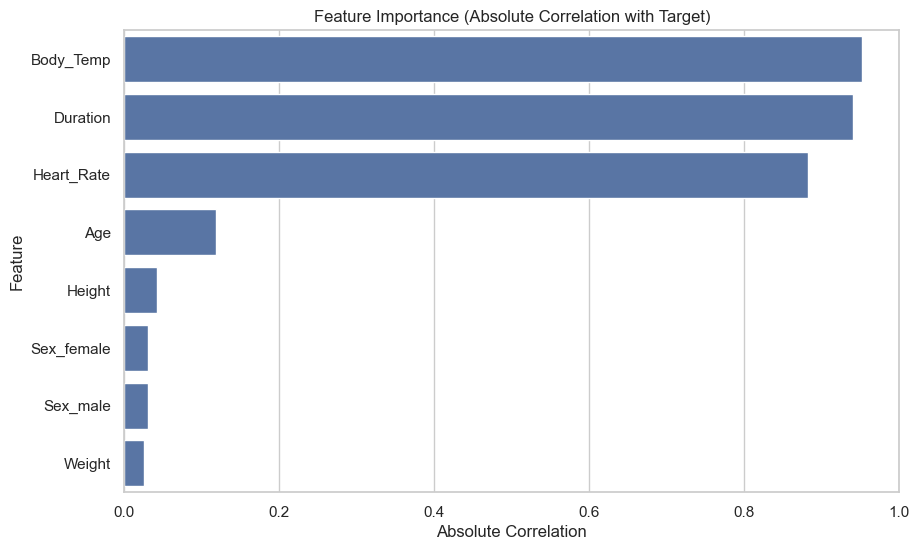

Feature importance by correlation:
      Feature  Absolute Correlation
0   Body_Temp              0.952895
1    Duration              0.940099
2  Heart_Rate              0.882031
3         Age              0.118523
4      Height              0.042126
5  Sex_female              0.030388
6    Sex_male              0.030388
7      Weight              0.025528


In [27]:
feature_importance_corr = plot_feature_importances_correlation(X_train, y_train)
print("Feature importance by correlation:")
print(feature_importance_corr)

In [28]:
def select_best_features_using_selectkbest(X_train, y_train, X_test, k= 5):
    selector= SelectKBest(score_func=f_regression, k=k)
    X_train_selected= selector.fit_transform(X_train, y_train)
    X_test_selected= selector.transform(X_test)

    # Get the selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices]

    scores= pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
    scores= scores.sort_values(by= 'Score', ascending= False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x= 'Score', y= 'Feature', data= scores)
    plt.title('Feature Importance using SelectKBest')
    plt.show()
    return X_train_selected, X_test_selected, selected_features, scores

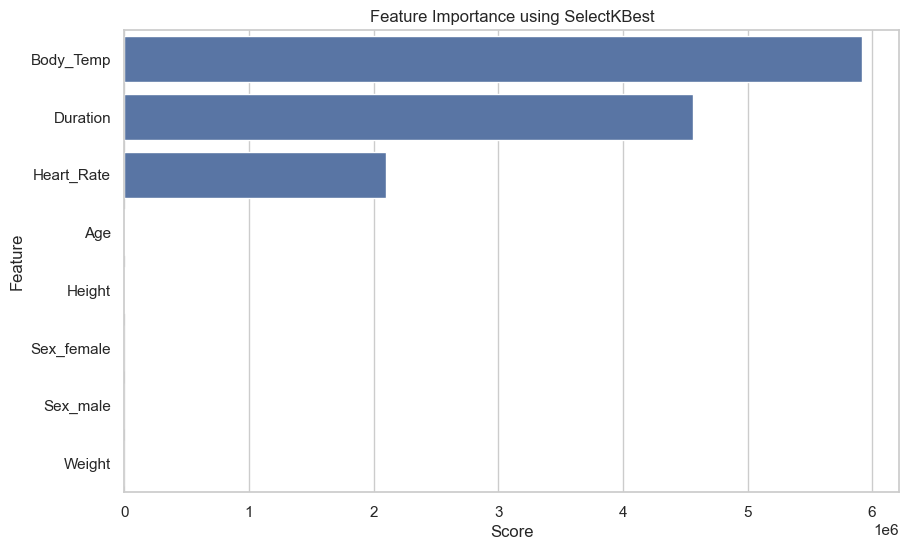

In [29]:
X_train_selected, X_test_selected, selected_features, feature_scores = select_best_features_using_selectkbest(X_train, y_train, X_test, k=5)

In [30]:
print("Selected features (SelectKBest):")
print(selected_features)
print("\nFeature scores:")
print(feature_scores)

Selected features (SelectKBest):
Index(['Age', 'Height', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object')

Feature scores:
      Feature         Score
5   Body_Temp  5.922384e+06
3    Duration  4.562857e+06
4  Heart_Rate  2.102439e+06
0         Age  8.548673e+03
1      Height  1.066638e+03
6  Sex_female  5.545525e+02
7    Sex_male  5.545525e+02
2      Weight  3.912758e+02


In [31]:
def feature_engineering(X_train, X_test, selected_features):
    if len(selected_features) > 2:
        for i in range(len(selected_features)):
            for j in range(i + 1, len(selected_features)):
                feature_1 = selected_features[i]
                feature_2 = selected_features[j]
                X_train[f'{feature_1}_{feature_2}_interaction'] = X_train[feature_1] * X_train[feature_2]
                X_test[f'{feature_1}_{feature_2}_interaction'] = X_test[feature_1] * X_test[feature_2]
        
    for feature in selected_features[:3]:  # Top 3 features
        X_train[f'{feature}_squared'] = X_train[feature] ** 2
        X_test[f'{feature}_squared'] = X_test[feature] ** 2
    
    return X_train, X_test

In [32]:
X_train_engineered, X_test_engineered = feature_engineering(X_train.copy(), X_test.copy(), selected_features)

In [33]:
print("Original features shape:", X_train.shape)
print("Engineered features shape:", X_train_engineered.shape)
print("New features added:", list(set(X_train_engineered.columns) - set(X_train.columns)))

Original features shape: (600000, 8)
Engineered features shape: (600000, 21)
New features added: ['Height_squared', 'Age_Duration_interaction', 'Age_Body_Temp_interaction', 'Height_Body_Temp_interaction', 'Age_squared', 'Age_Heart_Rate_interaction', 'Height_Duration_interaction', 'Height_Heart_Rate_interaction', 'Heart_Rate_Body_Temp_interaction', 'Duration_Heart_Rate_interaction', 'Age_Height_interaction', 'Duration_Body_Temp_interaction', 'Duration_squared']


# Model Training and Evaluation

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"{model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Testing MAE: {test_mae:.2f}")
    print("-" * 50)
    
    return {
        'model_name': model_name,
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

In [39]:
def compare_models(models_results, metric='test_r2', ascending=False):
    results_df = pd.DataFrame(models_results)
    sorted_results = results_df.sort_values(by=metric, ascending=ascending)

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='model_name', y=metric, data=sorted_results)

    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45, ha='right')

    # Put values on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    return sorted_results

In [36]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=SEED),
    'Random Forest': RandomForestRegressor(random_state=SEED),
    'Gradient Boosting': GradientBoostingRegressor(random_state=SEED),
    'K-Neighbors': KNeighborsRegressor(),
    'MLP Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=SEED, max_iter=50)
}

In [37]:
models_results = []
for name, model in models.items():
    result = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    models_results.append(result)

Linear Regression Performance:
Training RMSE: 0.19
Testing RMSE: 0.19
Training R²: 0.9614
Testing R²: 0.9617
Training MAE: 0.14
Testing MAE: 0.14
--------------------------------------------------
Ridge Regression Performance:
Training RMSE: 0.19
Testing RMSE: 0.19
Training R²: 0.9614
Testing R²: 0.9617
Training MAE: 0.14
Testing MAE: 0.14
--------------------------------------------------
Lasso Regression Performance:
Training RMSE: 0.24
Testing RMSE: 0.24
Training R²: 0.9400
Testing R²: 0.9403
Training MAE: 0.17
Testing MAE: 0.17
--------------------------------------------------
ElasticNet Performance:
Training RMSE: 0.21
Testing RMSE: 0.21
Training R²: 0.9524
Testing R²: 0.9526
Training MAE: 0.15
Testing MAE: 0.15
--------------------------------------------------
Decision Tree Performance:
Training RMSE: 0.00
Testing RMSE: 0.09
Training R²: 1.0000
Testing R²: 0.9919
Training MAE: 0.00
Testing MAE: 0.05
--------------------------------------------------
Random Forest Performance:
T

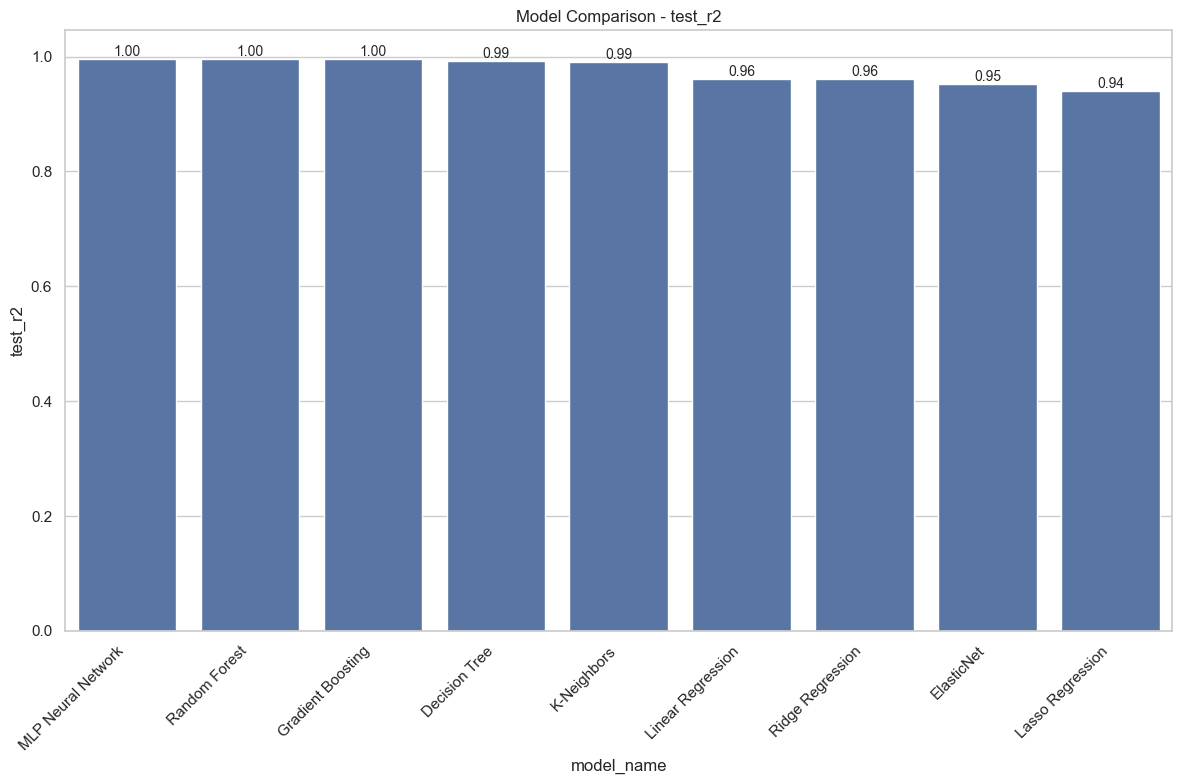

Models ranked by test R²:
           model_name   test_r2  test_rmse
8  MLP Neural Network  0.995693   0.063167
5       Random Forest  0.995646   0.063516
6   Gradient Boosting  0.995128   0.067184
4       Decision Tree  0.991948   0.086372
7         K-Neighbors  0.991289   0.089838
0   Linear Regression  0.961748   0.188255
1    Ridge Regression  0.961748   0.188255
3          ElasticNet  0.952628   0.209497
2    Lasso Regression  0.940268   0.235247


In [40]:
basic_models_comparison = compare_models(models_results, metric='test_r2', ascending=False)
print("Models ranked by test R²:")
print(basic_models_comparison[['model_name', 'test_r2', 'test_rmse']])